# Importing Necessary Libraries

In [11]:

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

In [12]:
warnings.filterwarnings('ignore')

# Load the Dataset

In [13]:

df_path = "Churn_Modelling.csv"  # Update path if necessary
df = pd.read_csv(df_path)


In [14]:
# Display Basic Information
print("Dataset Shape:", df.shape)


Dataset Shape: (10000, 14)


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [16]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [17]:
# Describe the dataset
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Data Visualization and Analysis

In [20]:
def visualize_categorial_distributions(df):
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Set up the figure with dynamic height based on the number of categories
    fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(12, len(categorical_columns) * 5))
    fig.suptitle("Distribution of Categorical Features", fontsize=18, fontweight="bold")

    # If there is only one categorical column, make axes iterable
    if len(categorical_columns) == 1:
        axes = [axes]

    # Iterate over each categorical column and create a count plot
    for i, col in enumerate(categorical_columns):
        sns.countplot(
            data=df,
            x=col,
            ax=axes[i],
            palette='magma',
            order=df[col].value_counts().index
        )
        # Setting titles and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=14, fontweight="bold")
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel("Count", fontsize=12)
        axes[i].tick_params(axis='x', rotation=30)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


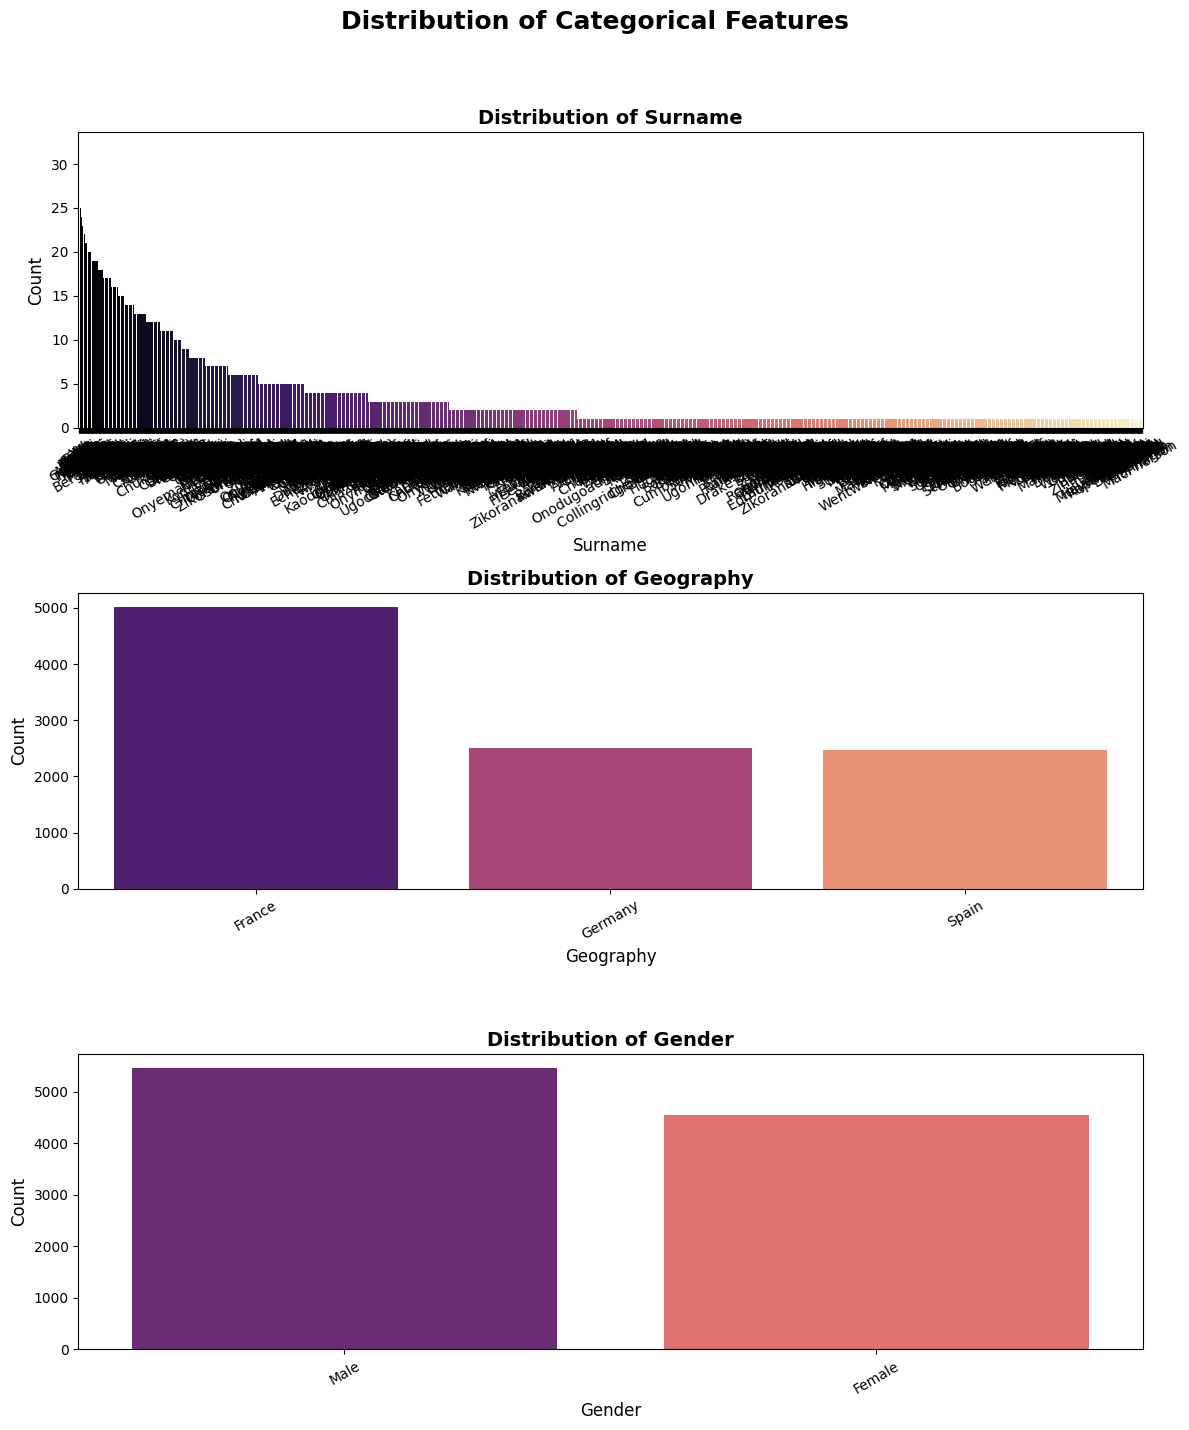

In [21]:
visualize_categorial_distributions(df)

In [22]:
def visualize_numerical_distributions(df, exclude_columns=['RowNumber', 'CustomerId', "Exited"]):
    """
    Visualizes the distribution of numerical features in the DataFrame using histograms and KDE plots,
    excluding specified columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    - exclude_columns (list): List of column names to exclude from visualization.

    Returns:
    - None: Displays the plots.
    """
    # Ensure exclude_columns is a list
    if exclude_columns is None:
        exclude_columns = []

    # Identify numerical columns and exclude specified ones
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

    # Set up a single-column figure for a clear vertical layout
    fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(16, len(numerical_columns) * 5))
    fig.suptitle('Distribution of Numerical Features', fontsize=18, fontweight='bold')

    # Ensure axes is always 2D for easier indexing
    if len(numerical_columns) == 1:
        axes = [axes]

    # Iterate over each numerical column and create plots
    for i, col in enumerate(numerical_columns):
        # Histogram
        sns.histplot(df[col], bins=30, color="cornflowerblue", edgecolor="black", ax=axes[i, 0])
        axes[i, 0].set_title(f'Histogram of {col}', fontsize=14, fontweight='bold')
        axes[i, 0].set_xlabel(col, fontsize=12)
        axes[i, 0].set_ylabel('Count', fontsize=12)

        # KDE plot
        sns.kdeplot(df[col], fill=True, color="crimson", linewidth=2, ax=axes[i, 1])
        axes[i, 1].set_title(f'KDE of {col}', fontsize=14, fontweight='bold')
        axes[i, 1].set_xlabel(col, fontsize=12)
        axes[i, 1].set_ylabel('Density', fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


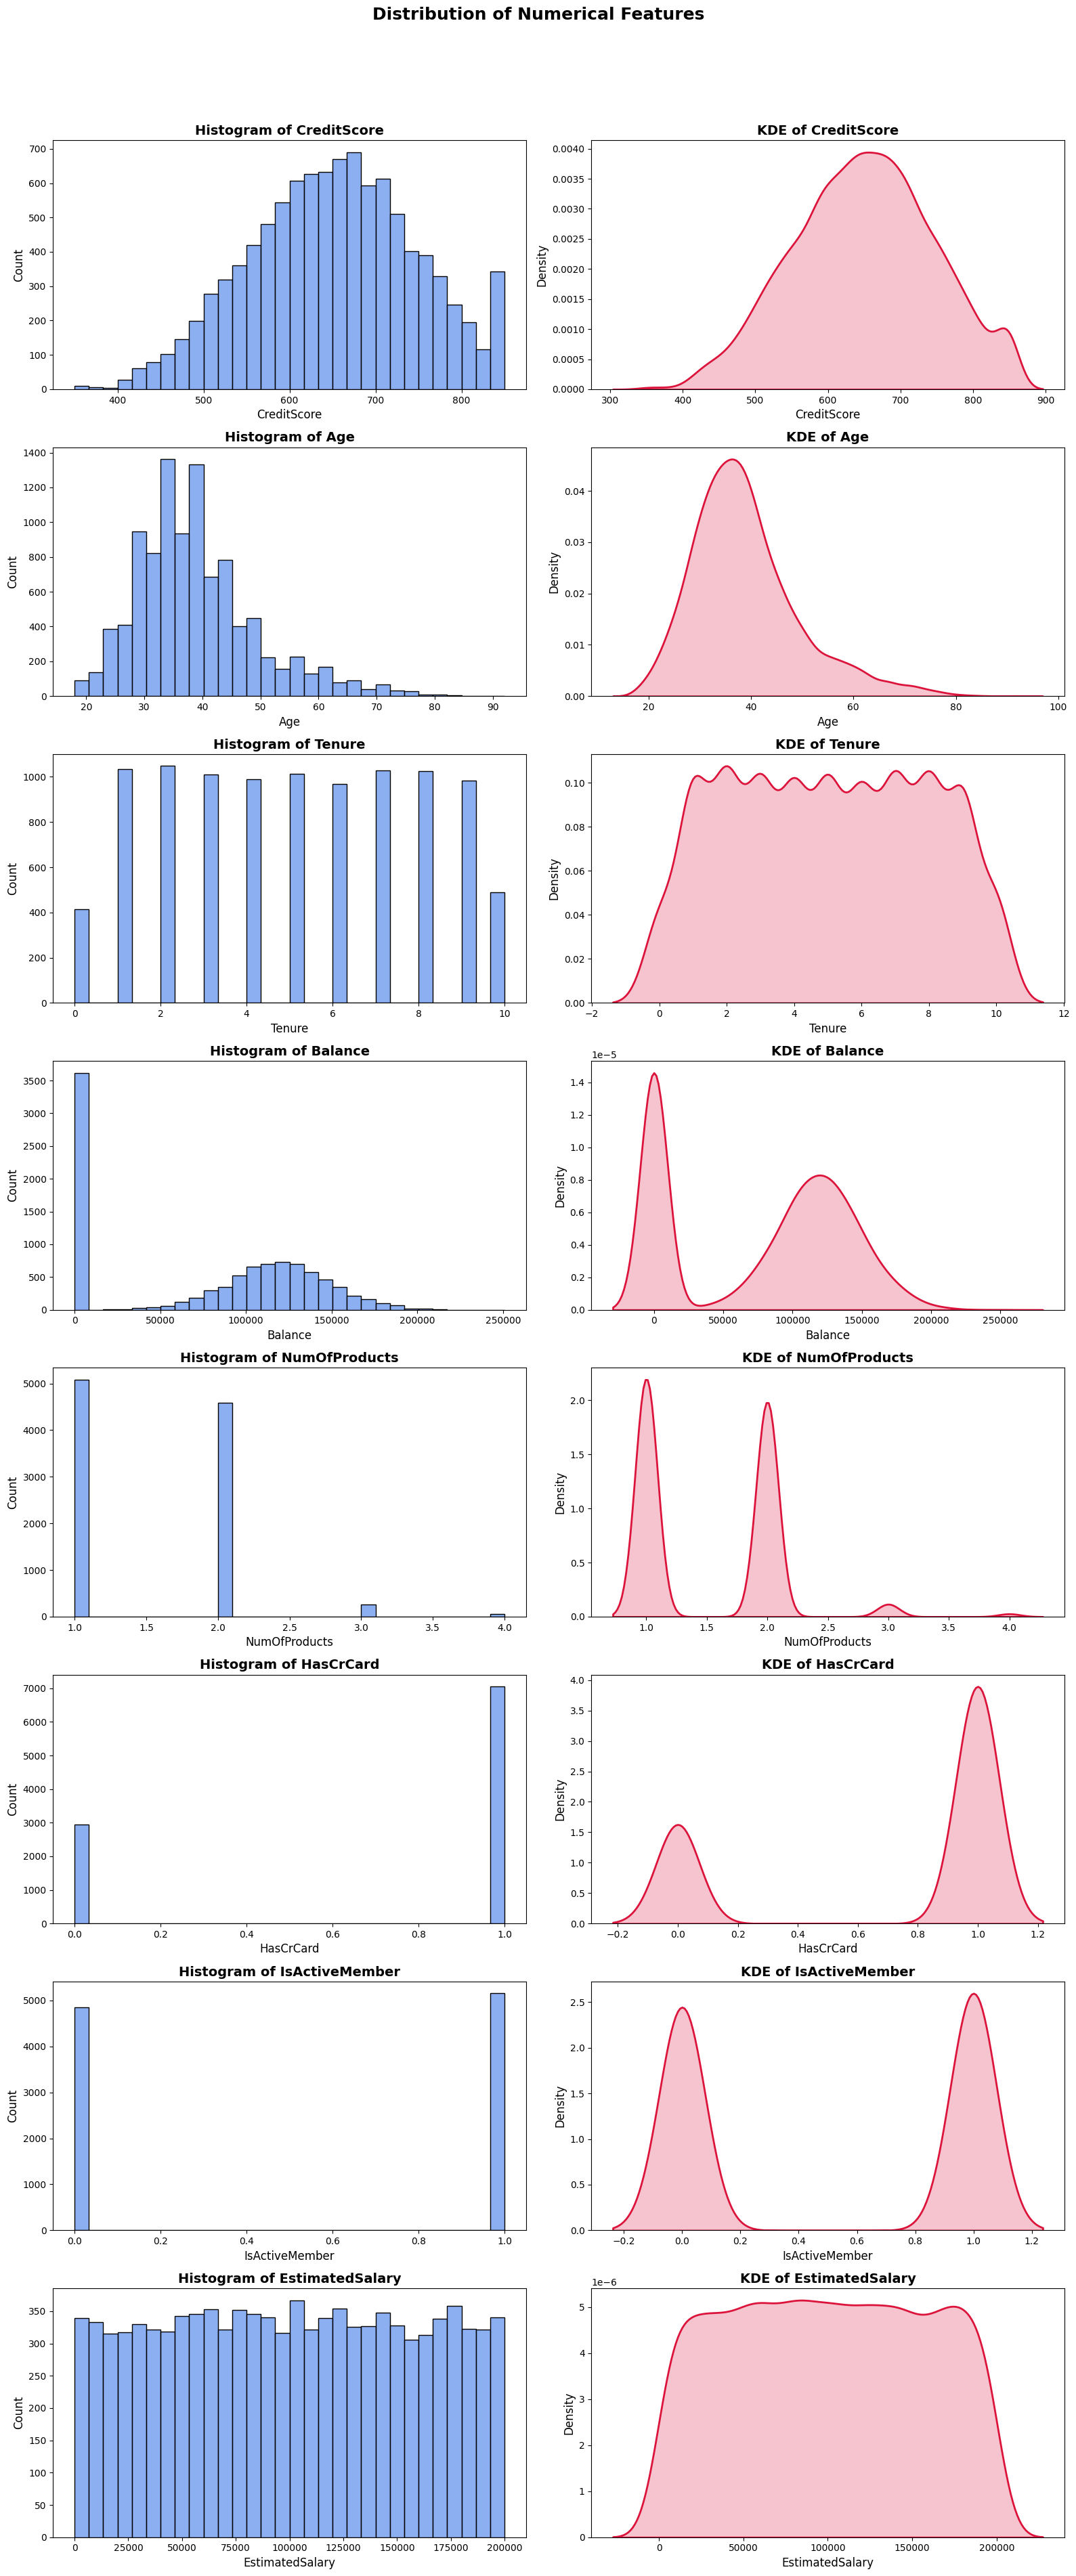

In [23]:
visualize_numerical_distributions(df)

# Feature One Hot Encoder

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

In [26]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Geography']]).toarray()
        column_names = ['France', 'Germany', 'Spain']

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

# Feature Label Encoder

In [27]:
class FeatureLabel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        label_encoder = LabelEncoder()
        X['Gender'] = label_encoder.fit_transform(X['Gender'])
        return X


# Feature Dropper

In [28]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography'], axis=1, errors='ignore')

# Creating The Pipeline

In [30]:
from sklearn.pipeline import Pipeline

In [31]:
pipeline = Pipeline([
    ('feature_encoder', FeatureEncoder()),
    ('feature_label', FeatureLabel()),
    ('feature_dropper', FeatureDropper()),
])

In [32]:
train_data = pipeline.fit_transform(df)

In [33]:
train_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


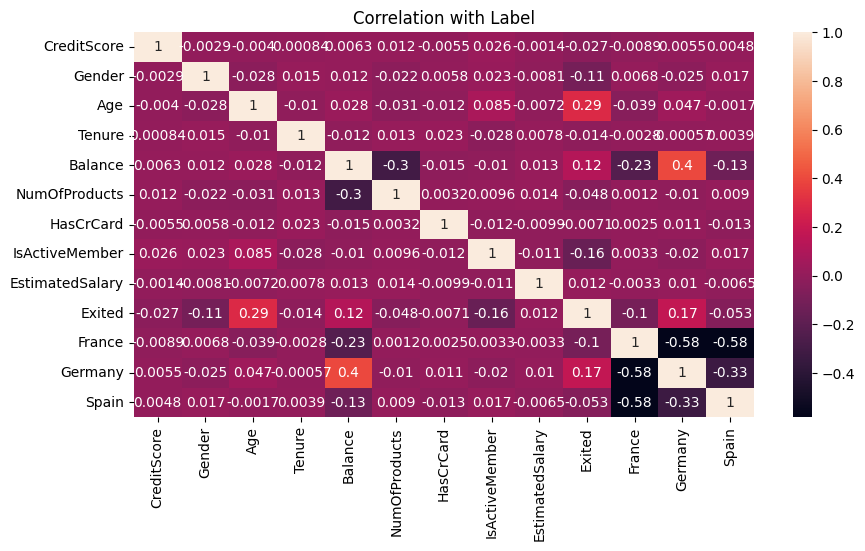

In [39]:
corr_train_data = train_data.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(data=corr_train_data, annot=True)
plt.title("Correlation with Label")
plt.show()

#Create The Features and Label

In [40]:
# Create features and label
X = train_data.drop("Exited", axis=1)
y = train_data['Exited']

In [41]:
# Spliting the dataset into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

pred_1 = model_1.predict(X_test)

In [44]:
from sklearn.naive_bayes import BernoulliNB

model_2 = BernoulliNB()
model_2.fit(X_train, y_train)

pred_2 = model_2.predict(X_test)

In [45]:
from sklearn.ensemble import RandomForestClassifier

model_3 = RandomForestClassifier()
model_3.fit(X_train, y_train)

pred_3 = model_3.predict(X_test)

In [46]:
from xgboost import XGBClassifier

model_4 = XGBClassifier()
model_4.fit(X_train, y_train)

pred_4 = model_4.predict(X_test)

In [47]:
from sklearn.svm import SVC

model_5 = SVC()
model_5.fit(X_train, y_train)

pred_5 = model_5.predict(X_test)


In [48]:
from sklearn.neighbors import KNeighborsClassifier

model_6 = KNeighborsClassifier(n_neighbors=5)
model_6.fit(X_train, y_train)

pred_6 = model_6.predict(X_test)

In [49]:

from sklearn.ensemble import GradientBoostingClassifier

model_7 = GradientBoostingClassifier()
model_7.fit(X_train, y_train)

pred_7 = model_7.predict(X_test)


In [50]:
from sklearn.tree import DecisionTreeClassifier

model_8 = DecisionTreeClassifier()
model_8.fit(X_train, y_train)

pred_8 = model_8.predict(X_test)

#Evaluate the model

Evaluating the Models:
Logistic Regression Model Accuracy: 0.8000


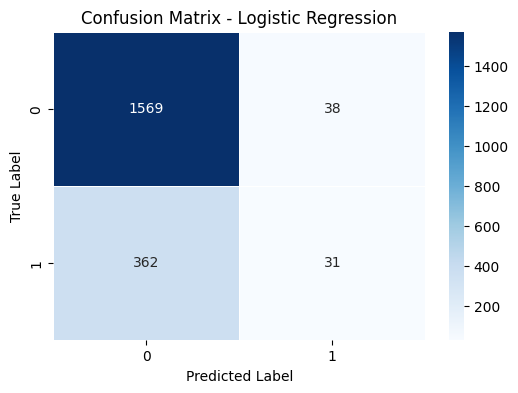

BernoulliNB Model Accuracy: 0.8000


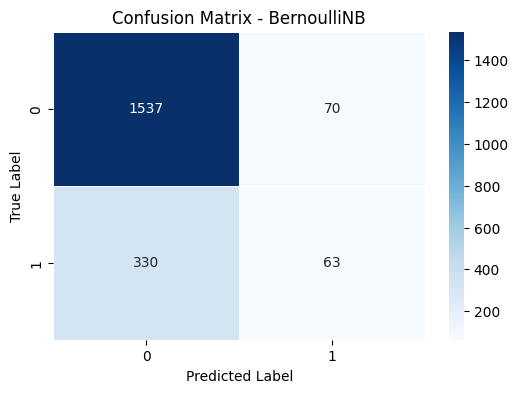

RandomForestClassifier Model Accuracy: 0.8670


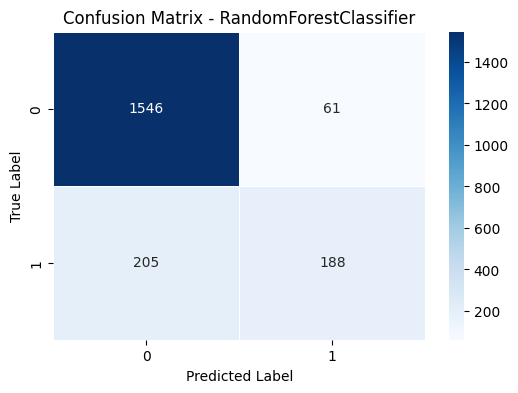

XGBClassifier Model Accuracy: 0.8625


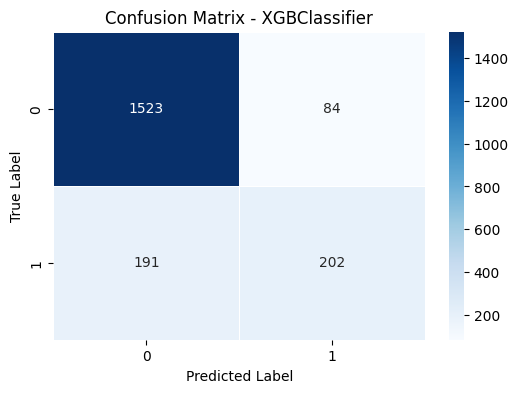

SVC Model Accuracy: 0.8035


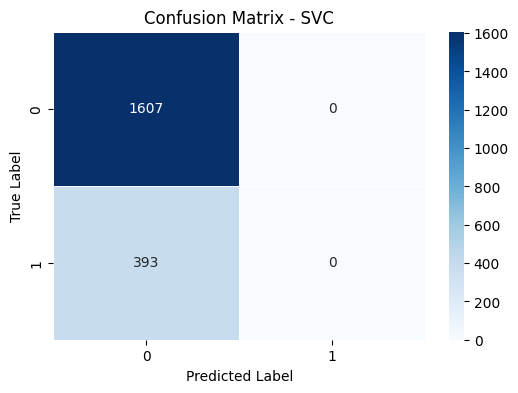

KNN Model Accuracy: 0.7640


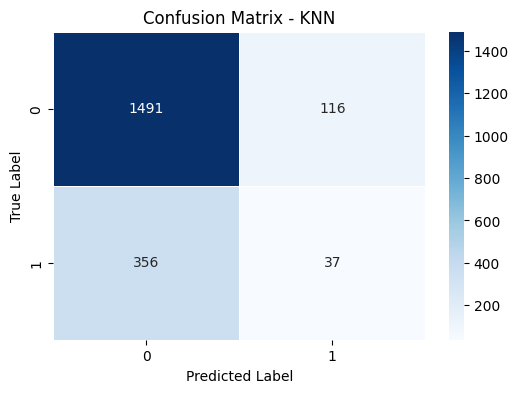

Gradient Boosting Model Accuracy: 0.8645


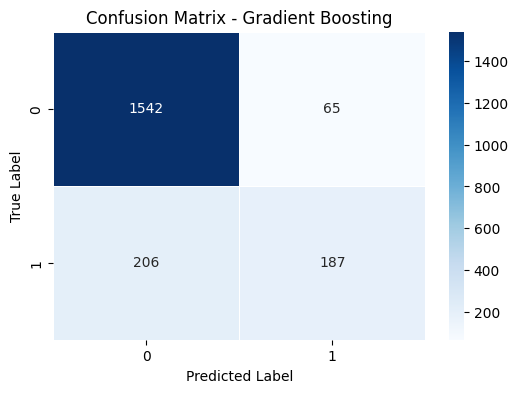

Decision Tree Model Accuracy: 0.7795


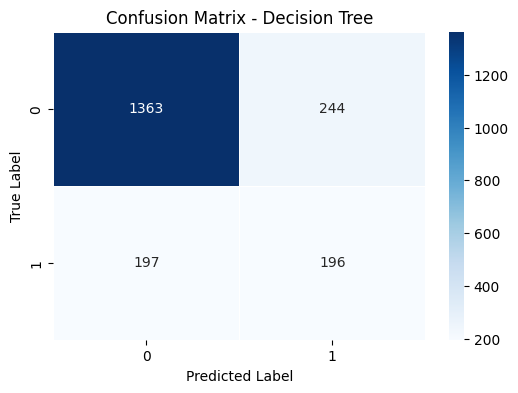

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Evaluating all models
print("Evaluating the Models:")
print("=" * 40)

models = {
    "Logistic Regression": pred_1,
    "BernoulliNB": pred_2,
    "RandomForestClassifier": pred_3,
    "XGBClassifier": pred_4,
    "SVC": pred_5,
    "KNN": pred_6,
    "Gradient Boosting": pred_7,
    "Decision Tree": pred_8
}

for model_name, predictions in models.items():
    acc = accuracy_score(y_test, predictions)
    print(f"{model_name} Model Accuracy: {acc:.4f}")
    plot_confusion_matrix(y_test, predictions, model_name)

print("=" * 40)


In [51]:
from sklearn.metrics import accuracy_score

print("Evaluating the Models:")
print("=" * 40)

print("Logistic Regression Model AC:", accuracy_score(y_test, pred_1))
print("BernoulliNB Model AC:", accuracy_score(y_test, pred_2))
print("RandomForestClassifier Model AC:", accuracy_score(y_test, pred_3))
print("XGBClassifier Model AC:", accuracy_score(y_test, pred_4))
print("SVC Model AC:", accuracy_score(y_test, pred_5))
print("KNN Model AC:", accuracy_score(y_test, pred_6))
print("Gradient Boosting Model AC:", accuracy_score(y_test, pred_7))
print("Decision Tree Model AC:", accuracy_score(y_test, pred_8))

print("=" * 40)


Evaluating the Models:
Logistic Regression Model AC: 0.8
BernoulliNB Model AC: 0.8
RandomForestClassifier Model AC: 0.867
XGBClassifier Model AC: 0.8625
SVC Model AC: 0.8035
KNN Model AC: 0.764
Gradient Boosting Model AC: 0.8645
Decision Tree Model AC: 0.7795


#Save the Model

In [54]:
import pickle

model_name = "customer_churn_model.pkl"

with open(model_name, 'wb') as file:
    pickle.dump(model_3, file)